In [1]:
import angle_extraction as aex
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy,os,glob
from scipy.optimize import minimize
import time

In [2]:
file_list = glob.glob('C:/Users/Jason.Bane/Documents/Nautilus/DOE_stage/code_trials/images/*.BMP')
img_index = 0  # Change this to select different images from the file_list

Line 1: y = -0.497x + 1095.3
Line 2: y = -1.853x + 2229.7
Number of inliers for line 1: 62 out of 76
Number of inliers for line 2: 13 out of 14
Intersection at x=836.6, y=679.5
Angle of line 1 before quadrant adjustment: 26.4°
Angle of line 2 before quadrant adjustment: -61.6°
--------------------------------------------------
Total points: 76
Line 1 total points: 62
Line 1 quadrant counts: Q1=30, Q2=0, Q3=32, Q4=0
Line 2 quadrant counts: Q1=0, Q2=0, Q3=13, Q4=0
Line 2 lies in quadrant: 3
Line 1 angle = 206.43°, Line 2 angle = -61.65°
Intersection point: (836.63, 679.52)
Time to process image 00000: 0.20 seconds
Angle info: (np.float64(206.4277118173697), np.float64(-61.64505673306035), (np.float64(836.625657512149), np.float64(679.5215607040668)))


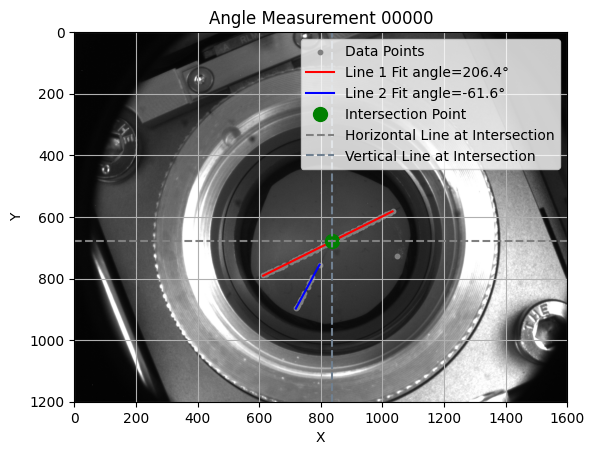

In [3]:
# img_number="00023"
# image_file_name=f"C:\\Users\\Jason.Bane\\Documents\\Nautilus\\DOE_stage\\code_trials\\images\\Image{img_number}.BMP"
start = time.time()

image_file_name = file_list[img_index%len(file_list)]
img_index += 1
image_number = os.path.splitext(os.path.basename(image_file_name))[0]
img_number = image_number[-5:]  # Extract the last 5 characters for img_number



image = cv2.imread(image_file_name)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


#Edges = aex.horizontal_edges(image,resolution=50,plot=1)
#Circle = aex.Center_Radius_iterations(peaks=Edges, max_iterations=10, threshold=0.02, plot=True, verbose=False)  

Verticle_scan = aex.vertical_scan_for_center_peaks(image, resolution=10, plot=0, verbose=False)
Horizontal_scan = aex.horizontal_scan_for_center_peaks(image, resolution=10, plot=0, verbose=False)

#stack the two scans to get the center
Scan = np.vstack((Horizontal_scan,Verticle_scan))


line_info = aex.two_line_fit_with_rotation(Scan, plot=False, verbose=True)


Angle_info=aex.Angle_Measurment(image,Scan,line_info,plot=True,verbose=True,image_number=img_number)

finish = time.time()
print(f"Time to process image {img_number}: {finish - start:.2f} seconds")
print("Angle info:", Angle_info)

In [4]:
def find_two_lines(data, plot=True, verbose=False):
    """
    Find two lines in the given 2D data using RANSAC algorithm.

    Parameters:
    data (numpy.ndarray): A 2D array of shape (N, 2) where each row represents a point (x, y).
    plot (bool): If True, plot the data points and the fitted lines.
    verbose (bool): If True, print additional information during processing.

    Returns:
    tuple: Coefficients of the two lines in the form (slope1, intercept1, slope2, intercept2).
    """
        
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.linear_model import RANSACRegressor, LinearRegression




    points = data

    points = np.array(points)
    # radomly  sort the points
    print(points[0])
    np.random.shuffle(points)
    print(points[0])



    X = points[:,0].reshape(-1,1)
    y = points[:,1]

    # Use RANSAC to detect first line
    ransac1 = RANSACRegressor(LinearRegression(), residual_threshold=5, random_state=0)
    ransac1.fit(X, y)
    inlier_mask1 = ransac1.inlier_mask_
    outlier_mask1= np.logical_not(inlier_mask1)

    y_pred1 = ransac1.predict(X[inlier_mask1])

    #standard devoation of residuals
    residuals1 = np.abs(y[inlier_mask1] - y_pred1)

    Full_pred = ransac1.predict(X)

    Full_residuals = np.abs(y-Full_pred)

    # fit new line to data that has Full_residulas <2
    low_residuals_mask = Full_residuals < 2
    ranscac1_1 = RANSACRegressor(LinearRegression(), residual_threshold=15, random_state=10)
    ranscac1_1.fit(X[low_residuals_mask], y[low_residuals_mask])

    
    x1_1 = np.arange(X[low_residuals_mask].min(),X[low_residuals_mask].max(),0.1).reshape(-1,1)
    y1_1 = ranscac1_1.predict(x1_1) 

    fig, ax  = plt.subplots()
    plt.scatter(X[low_residuals_mask], y[low_residuals_mask],
                 marker="D",color="magenta", s=30, label="data_low_residuals")




    print(Full_residuals[::10])
    

    X_remaing = X[outlier_mask1]
    y_remaining = y[outlier_mask1]
    # Use RANSAC on remaining points for second line
    ransac2 = RANSACRegressor(LinearRegression(), residual_threshold=5, random_state=1)
    ransac2.fit(X_remaing, y_remaining)
    inlier_mask2 = ransac2.inlier_mask_

    y_pred2 = ransac2.predict(X_remaing[inlier_mask2])
    #standard devoation of residuals
    residuals2 = np.abs(y_remaining[inlier_mask2] - y_pred2)

    
    #slopes and intercepts
    slope1 = ransac1.estimator_.coef_[0]
    intercept1 = ransac1.estimator_.intercept_
    slope2 = ransac2.estimator_.coef_[0]
    intercept2 = ransac2.estimator_.intercept_

    line_x2 = np.arange(X_remaing[inlier_mask2].min(),X_remaing[inlier_mask2].max(),0.1)
    line_y2 = slope2 * line_x2 + intercept2

    line_x1 = np.arange(X[inlier_mask1].min(),X[inlier_mask1].max(),0.1)
    line_y1 = slope1 * line_x1 + intercept1
    # Plot

    #length of lines
    line1_length = np.sqrt((line_x1[-1]-line_x1[0])**2 + (line_y1[-1]-line_y1[0])**2)
    line2_length = np.sqrt((line_x2[-1]-line_x2[0])**2 + (line_y2[-1]-line_y2[0])**2)
    if verbose:
            print("Standard deviation of residuals for line 1:", np.std(residuals1))
            print("Number of inliers for line 1:", np.sum(inlier_mask1), "out of", len(y))
            print("Standard deviation of residuals for line 2:", np.std(residuals2))
            print("Number of inliers for line 2:", np.sum(inlier_mask2), "out of", len(y_remaining))
            print(f"Line 1 length: {line1_length}, Line 2 length: {line2_length}")

    # if line1_length < line2_length:
    #     print("Warning: Line 1 is shorter than Line 2.")
    #     temp_slope = slope1
    #     slope1 = slope2
    #     slope2 = temp_slope
    #     temp_intercept = intercept1
    #     intercept1 = intercept2
    #     intercept2 = temp_intercept

    #     temp_line_x = line_x1
    #     line_x1 = line_x2   
    #     line_x2 = temp_line_x

    #     temp_line_y = line_y1
    #     line_y1 = line_y2
    #     line_y2 = temp_line_y

    if plot:
        # plot the first inliners and its prediction
        # fig, ax  = plt.subplots()
        plt.scatter(X[inlier_mask1], y[inlier_mask1],
                     color="gray",marker="d", s=20, label="data_line1",)
        plt.scatter(X[inlier_mask1], y_pred1, 
                    color="green",marker="+", s=20, label="line1 inliers")  

        plt.scatter(X_remaing[inlier_mask2], y_remaining[inlier_mask2],
                     color="slategray", marker="o", s=20, label="data_line2")
        plt.scatter(X_remaing[inlier_mask2], y_pred2, color="blue", marker="x", s=20, label="line2 inliers")

        final_remaing_x = X_remaing[~inlier_mask2]
        final_remaing_y = y_remaining[~inlier_mask2]

        plt.scatter(final_remaing_x, final_remaing_y, color="red", marker="s", s=20, label="line2 outliers")
        plt.plot(line_x1, line_y1, "g-", label="Line 1 fit")
        plt.plot(line_x2, line_y2, "b-", label="Line 2 fit")    
        ax.yaxis.set_inverted(True)
        plt.grid()
        plt.legend()
        plt.show()
    print(X[0], y[0])
    #x and y points for the two fits
    points_1 = np.hstack((X[inlier_mask1], np.array(y[inlier_mask1]).reshape(-1,1)))
    points_2 = np.hstack((X_remaing[inlier_mask2], np.array(y_remaining[inlier_mask2]).reshape(-1,1)))
    return slope1, intercept1, slope2, intercept2 ,points_1, points_2




In [5]:
def fit_two_lines_ransac_improved(points, residual_threshold=10.0, min_angle_deg=15.0, 
                                 max_residual_score=0.5, min_inliers_ratio=0.1, 
                                 max_attempts=50, plot=True, verbose=True):
    """
    Fit two lines to point data using RANSACRegressor with LinearRegression.
    Validates angle separation and residual quality for robust fitting.
    
    Parameters:
    -----------
    points : array-like, shape (n_points, 2)
        x, y coordinates of points
    residual_threshold : float, default=10.0
        Maximum distance from line to be considered inlier
    min_angle_deg : float, default=15.0
        Minimum angle difference between lines in degrees
    max_residual_score : float, default=0.5
        Maximum allowed mean residual score (lower is better)
    min_inliers_ratio : float, default=0.3
        Minimum ratio of points that must be inliers for each line
    max_attempts : int, default=50
        Maximum number of random state attempts to find good fit
    plot : bool, default=True
        Whether to plot the results
    verbose : bool, default=True
        Whether to print fitting progress
        
    Returns:
    --------
    result : dict
        Dictionary containing:
        - 'line1_params': (slope, intercept) for line 1
        - 'line2_params': (slope, intercept) for line 2
        - 'inliers1': boolean mask for line 1 inliers
        - 'inliers2': boolean mask for line 2 inliers
        - 'fit_quality': dict with quality metrics
        - 'success': bool indicating if criteria were met
    """
    from sklearn.linear_model import RANSACRegressor, LinearRegression
    points = np.array(points)
    # radomly  sort the points
    np.random.shuffle(points)



    if len(points) < 6:  # Need at least 3 points per line
        if verbose:
            print("Error: Need at least 6 points to fit two lines")
        return None
    
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    min_angle_rad = np.deg2rad(min_angle_deg)
    min_inliers_per_line = int(len(points) * min_inliers_ratio)
    
    best_fit = None
    best_score = float('inf')
    
    if verbose:
        print(f"Attempting to fit two lines to {len(points)} points...")
        print(f"Criteria: min_angle≥{min_angle_deg}°, max_residual≤{max_residual_score}, min_inliers≥{min_inliers_per_line}")
    
    for attempt in range(max_attempts):
        try:
            # Fit first line using RANSAC
            ransac1 = RANSACRegressor(
                LinearRegression(), 
                residual_threshold=residual_threshold, 
                random_state=attempt,
                min_samples=2
            )
            ransac1.fit(X, y)
            inlier_mask1 = ransac1.inlier_mask_
            
            # Check if first line has enough inliers
            if np.sum(inlier_mask1) < min_inliers_per_line:
                continue
            
            # Fit second line to remaining points
            X_remaining = X[~inlier_mask1]
            y_remaining = y[~inlier_mask1]
            
            if len(X_remaining) < min_inliers_per_line:
                continue
                
            ransac2 = RANSACRegressor(
                LinearRegression(),
                residual_threshold=residual_threshold,
                random_state=attempt + 1,
                min_samples=2
            )
            ransac2.fit(X_remaining, y_remaining)
            inlier_mask2_subset = ransac2.inlier_mask_
            
            # Map second line inliers back to original indices
            inlier_mask2 = np.zeros(len(points), dtype=bool)
            remaining_indices = np.where(~inlier_mask1)[0]
            inlier_mask2[remaining_indices[inlier_mask2_subset]] = True
            
            # Check if second line has enough inliers
            if np.sum(inlier_mask2) < min_inliers_per_line:
                continue
            
            # Get line parameters
            line1_slope = ransac1.estimator_.coef_[0]
            line1_intercept = ransac1.estimator_.intercept_
            line2_slope = ransac2.estimator_.coef_[0]
            line2_intercept = ransac2.estimator_.intercept_
            
            # Calculate angle between lines
            angle1 = np.arctan(line1_slope)
            angle2 = np.arctan(line2_slope)
            angle_diff = abs(angle1 - angle2)
            
            # Handle angle wraparound
            if angle_diff > np.pi/2:
                angle_diff = np.pi - angle_diff
            
            # Check angle criterion
            if angle_diff < min_angle_rad:
                continue
            
            # Calculate residual quality for both lines
            y_pred1 = line1_slope * X.flatten() + line1_intercept
            y_pred2 = line2_slope * X.flatten() + line2_intercept
            
            # Calculate residuals for inliers only
            residuals1 = np.abs(y[inlier_mask1] - y_pred1[inlier_mask1])
            residuals2 = np.abs(y[inlier_mask2] - y_pred2[inlier_mask2])
            
            mean_residual1 = np.mean(residuals1)
            mean_residual2 = np.mean(residuals2)
            overall_residual = (mean_residual1 + mean_residual2) / 2
            
            # Check residual criterion
            if overall_residual > max_residual_score * residual_threshold:
                continue
            
            # Calculate fit quality score (lower is better)
            angle_score = 1.0 / (1.0 + angle_diff)  # Prefer larger angles
            residual_score = overall_residual / residual_threshold
            coverage_score = 1.0 - (np.sum(inlier_mask1) + np.sum(inlier_mask2)) / len(points)
            
            total_score = angle_score + residual_score + coverage_score
            
            if total_score < best_score:
                best_score = total_score
                best_fit = {
                    'line1_params': (line1_slope, line1_intercept),
                    'line2_params': (line2_slope, line2_intercept),
                    'inliers1': inlier_mask1.copy(),
                    'inliers2': inlier_mask2.copy(),
                    'fit_quality': {
                        'angle_diff_deg': np.rad2deg(angle_diff),
                        'mean_residual1': mean_residual1,
                        'mean_residual2': mean_residual2,
                        'overall_residual': overall_residual,
                        'inliers1_count': np.sum(inlier_mask1),
                        'inliers2_count': np.sum(inlier_mask2),
                        'outliers_count': len(points) - np.sum(inlier_mask1) - np.sum(inlier_mask2),
                        'coverage_ratio': (np.sum(inlier_mask1) + np.sum(inlier_mask2)) / len(points),
                        'quality_score': total_score
                    },
                    'success': True,
                    'ransac1': ransac1,
                    'ransac2': ransac2
                }
                
                if verbose and attempt % 10 == 0:
                    print(f"Attempt {attempt}: angle={np.rad2deg(angle_diff):.1f}°, "
                          f"residual={overall_residual:.2f}, score={total_score:.3f}")
        
        except Exception as e:
            if verbose and attempt % 20 == 0:
                print(f"Attempt {attempt} failed: {e}")
            continue
    
    if best_fit is None:
        if verbose:
            print("❌ Failed to find lines meeting all criteria")
        return {
            'line1_params': None,
            'line2_params': None,
            'inliers1': None,
            'inliers2': None,
            'fit_quality': None,
            'success': False
        }
    
    # Print results
    if verbose:
        print(f"\n✅ Successfully found two lines after {max_attempts} attempts:")
        print(f"Line 1: y = {best_fit['line1_params'][0]:.3f}x + {best_fit['line1_params'][1]:.3f}")
        print(f"Line 2: y = {best_fit['line2_params'][0]:.3f}x + {best_fit['line2_params'][1]:.3f}")
        print(f"Angle difference: {best_fit['fit_quality']['angle_diff_deg']:.1f}°")
        print(f"Mean residuals: {best_fit['fit_quality']['mean_residual1']:.2f}, {best_fit['fit_quality']['mean_residual2']:.2f}")
        print(f"Coverage: {best_fit['fit_quality']['coverage_ratio']:.1%}")
        print(f"Inliers: {best_fit['fit_quality']['inliers1_count']} + {best_fit['fit_quality']['inliers2_count']} = {best_fit['fit_quality']['inliers1_count'] + best_fit['fit_quality']['inliers2_count']}")
        print(f"Outliers: {best_fit['fit_quality']['outliers_count']}")
    
    # Plot results
    if plot:
        plt.figure(figsize=(12, 8))
        
        # Plot all points
        plt.scatter(points[:, 0], points[:, 1], c='lightgray', alpha=0.6, s=30, label='All points')
        
        # Plot inliers for each line
        inliers1 = best_fit['inliers1']
        inliers2 = best_fit['inliers2']
        
        if np.any(inliers1):
            plt.scatter(points[inliers1, 0], points[inliers1, 1], 
                       c='red', s=50, alpha=0.8, label=f'Line 1 inliers ({np.sum(inliers1)})')
        
        if np.any(inliers2):
            plt.scatter(points[inliers2, 0], points[inliers2, 1], 
                       c='blue', s=50, alpha=0.8, label=f'Line 2 inliers ({np.sum(inliers2)})')
        
        # Plot outliers
        outliers = ~(inliers1 | inliers2)
        if np.any(outliers):
            plt.scatter(points[outliers, 0], points[outliers, 1], 
                       c='black', marker='x', s=60, label=f'Outliers ({np.sum(outliers)})')
        
        # Plot fitted lines
        x_range = np.linspace(points[:, 0].min() - 10, points[:, 0].max() + 10, 100)

    

        #line two ends at line 1. 
        # x_range_line2 = np.linespace
        
        line1_slope, line1_intercept = best_fit['line1_params']
        line2_slope, line2_intercept = best_fit['line2_params']
        
        y_line1 = line1_slope * x_range + line1_intercept
        y_line2 = line2_slope * x_range + line2_intercept
        
        angle1_deg = np.rad2deg(np.arctan(line1_slope))
        angle2_deg = np.rad2deg(np.arctan(line2_slope))
        
        plt.plot(x_range, y_line1, 'r--', linewidth=3, alpha=0.8,
                label=f'Line 1: y={line1_slope:.3f}x+{line1_intercept:.1f} (θ={angle1_deg:.1f}°)')
        plt.plot(x_range, y_line2, 'b--', linewidth=3, alpha=0.8,
                label=f'Line 2: y={line2_slope:.3f}x+{line2_intercept:.1f} (θ={angle2_deg:.1f}°)')
        
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.title(f'RANSAC Two-Line Fitting (Angle diff: {best_fit["fit_quality"]["angle_diff_deg"]:.1f}°, '
                  f'Coverage: {best_fit["fit_quality"]["coverage_ratio"]:.1%})')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        plt.gca().invert_yaxis()
        xmin = points[:, 0].min() - 10
        xmax = points[:, 0].max() + 10
        ymin = points[:, 1].min() + 10
        ymax = points[:, 1].max() -10
        plt.xlim(xmin, xmax)
        plt.ylim(ymax, ymin)

    return best_fit

In [6]:
import glob
i=0
file_list = glob.glob("C:\\Users\\Jason.Bane\\Documents\\Nautilus\\DOE_stage\\code_trials\\images\\Image*.BMP")

Processing C:\Users\Jason.Bane\Documents\Nautilus\DOE_stage\code_trials\images\Image00000.BMP 
as Image00000
Line 1: y = -0.497x + 1095.0
Line 2: y = -1.860x + 2234.8
Number of inliers for line 1: 126 out of 152
Number of inliers for line 2: 23 out of 26
Intersection at x=836.1, y=679.8
Angle of line 1 before quadrant adjustment: 26.4°
Angle of line 2 before quadrant adjustment: -61.7°
Line 1: y = -0.497x + 1095.0
Line 2: y = -1.860x + 2234.8
Total points: 152
Line 1 total points: 126
Line 1 quadrant counts: Q1=59, Q2=0, Q3=66, Q4=1
Line 2 quadrant counts: Q1=0, Q2=0, Q3=23, Q4=0
Line 2 lies in quadrant: 3
Image 00000: Line 1 angle = 206.41°, Line 2 angle = -61.73°
Intersection point: (836.06, 679.83)


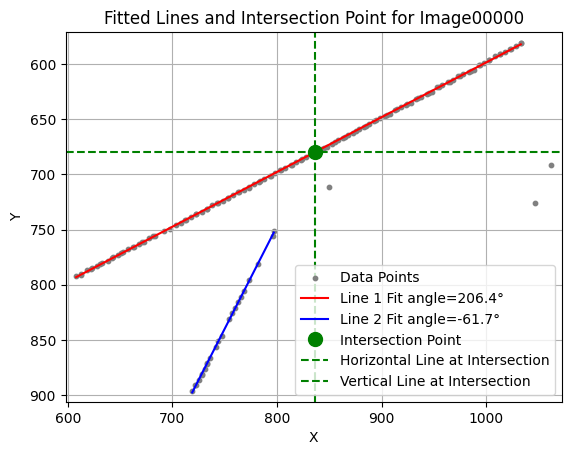

In [7]:
img_number="00038"

image_file_name=f"C:\\Users\\Jason.Bane\\Documents\\Nautilus\\DOE_stage\\code_trials\\images\\Image{img_number}.BMP"

image_file_name=f"{file_list[i%len(file_list)]}"
i+=1

file_number = os.path.basename(image_file_name).split('.')[0].replace('Image','')
img_number = file_number.zfill(5)
print(f"Processing {image_file_name} \nas Image{img_number}")

image = cv2.imread(image_file_name)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


Verticle_scan = aex.vertical_scan_for_center_peaks(image, resolution=5, plot=0, verbose=False)
Horizontal_scan = aex.horizontal_scan_for_center_peaks(image, resolution=5, plot=0, verbose=False)

#stack the two scans to get the center
Scan = np.vstack((Horizontal_scan,Verticle_scan))


line_info = aex.two_line_fit_with_rotation(Scan, plot=False, verbose=True)

#use 
line1_points = line_info[4]
line2_points = line_info[5]

line2_y_mean = np.mean(line2_points[:,1])
line2_x_mean = np.mean(line2_points[:,0])
#w

#Find the angle of the main line, using the secondary line to determine orientation
#Make the anlge be from the postive x axis, counter clockwise positive
#line 2 is the line 

Angle_line1 = np.abs(np.rad2deg(np.arctan(line_info[0])))
Angle_line2 = np.rad2deg(np.arctan(line_info[2]))

line1_m = line_info[0]
line1_b = line_info[1]

line2_m = line_info[2]
line2_b = line_info[3]

x_intersect = (line2_b - line1_b) / (line1_m - line2_m)
y_intersect = line1_m * x_intersect + line1_b

print(f"Intersection at x={x_intersect:.1f}, y={y_intersect:.1f}")
print(f"Angle of line 1 before quadrant adjustment: {Angle_line1:.1f}°")
print(f"Angle of line 2 before quadrant adjustment: {Angle_line2:.1f}°")
line2_quadrant = None
if line2_x_mean > x_intersect and line2_y_mean < y_intersect:
    line2_quadrant = 1
elif line2_x_mean < x_intersect and line2_y_mean < y_intersect:
    line2_quadrant = 2
    # Angle_line1 =  180-Angle_line1
    
elif line2_x_mean < x_intersect and line2_y_mean > y_intersect:
    line2_quadrant = 3
    # Angle_line1 =  Angle_line1 + 180
    
elif line2_x_mean > x_intersect and line2_y_mean > y_intersect:
    line2_quadrant = 4
    # Angle_line1 =  360-Angle_line1 
    
else:
    line2_quadrant = "On axis"


# arctan runs -90 to 90
# m1 = 0 horizontal, 0 or 180
## m2 in q3 makes m1 -> 180, 
# m1 < 0 , 0-90 or 180-270
## m2 in most of q1, tiny bit of q2, 0-90
## m2 most in q3, tiny bit of q4 , 180-270
#m1 > abs(90) vertical , 90 or 270
## m2 in q2 90, m2 in q4 270
#m1 > 0, 90-180 or 270-360
## m2 in most of q2, tiny bit of q3, 90-180
## m2 most in q4, tiny bit of q1 , 270-360
if np.abs(line1_m) > 100:
    #near vert
    if line2_quadrant == 2:
        if (np.abs(line2_m) -1.45) >0:
            Angle_line1 = Angle_line1
        else:
            Angle_line1 = 180-Angle_line1
    elif line2_quadrant==4:
        if (np.abs(line2_m) -1.4) >0:
            Angle_line1 = 270+Angle_line1
        else:
            Angle_line1 = 360-Angle_line1
elif line1_m < 0:
    if line2_quadrant == 3 or line2_quadrant ==4:
        Angle_line1 = 180+Angle_line1
    if line2_quadrant ==1 or line2_quadrant==2:
        Angle_line1=Angle_line1
elif line1_m >0:
    if line2_quadrant == 2 or line2_quadrant==3:
        Angle_line1 = Angle_line1 + 90
    elif line2_quadrant ==4 or line2_quadrant ==1:
        Angle_line1 = 360- Angle_line1 












#count of points of line 1 in each quadrant
line1_quadrant_counts = [0,0,0,0]
for point in line1_points:
    if point[0] > x_intersect and point[1] < y_intersect:
        line1_quadrant_counts[0] += 1
    elif point[0] < x_intersect and point[1] < y_intersect:
        line1_quadrant_counts[1] += 1
    elif point[0] < x_intersect and point[1] > y_intersect:
        line1_quadrant_counts[2] += 1
    elif point[0] > x_intersect and point[1] > y_intersect:
        line1_quadrant_counts[3] += 1

#count of points of line 2 in each quadrant
line2_quadrant_counts = [0,0,0,0]
for point in line2_points:
    if point[0] > x_intersect and point[1] < y_intersect:
        line2_quadrant_counts[0] += 1
    elif point[0] < x_intersect and point[1] < y_intersect:
        line2_quadrant_counts[1] += 1
    elif point[0] < x_intersect and point[1] > y_intersect:
        line2_quadrant_counts[2] += 1
    elif point[0] > x_intersect and point[1] > y_intersect:
        line2_quadrant_counts[3] += 1


#line 1 needs to have points in at least 2 quadrants
if sum([1 for count in line1_quadrant_counts if count > 1]) < 2:
    print("Warning: Line 1 does not span at least two quadrants")
    #switch line 1 and line 2
    temp_m = line1_m
    line1_m = line2_m
    line2_m = temp_m
    temp_b = line1_b
    line1_b = line2_b
    line2_b = temp_b
    temp_points = line1_points
    line1_points = line2_points
    line2_points = temp_points  
    temp_angle = Angle_line1
    Angle_line1 = Angle_line2
    Angle_line2 = temp_angle
    #recalculate intersection
    x_intersect = (line2_b - line1_b) / (line1_m - line2_m)
    y_intersect = line1_m * x_intersect + line1_b

print(f"Line 1: y = {line1_m:.3f}x + {line1_b:.1f}")
print(f"Line 2: y = {line2_m:.3f}x + {line2_b:.1f}")
#which quadrant is line 2 lie in



print(f"Total points: {len(Scan)}")
print(f"Line 1 total points: {len(line1_points)}")
print(f"Line 1 quadrant counts: Q1={line1_quadrant_counts[0]}, Q2={line1_quadrant_counts[1]}, Q3={line1_quadrant_counts[2]}, Q4={line1_quadrant_counts[3]}")
print(f"Line 2 quadrant counts: Q1={line2_quadrant_counts[0]}, Q2={line2_quadrant_counts[1]}, Q3={line2_quadrant_counts[2]}, Q4={line2_quadrant_counts[3]}")


print(f"Line 2 lies in quadrant: {line2_quadrant}")
print(f"Image {img_number}: Line 1 angle = {Angle_line1:.2f}°, Line 2 angle = {Angle_line2:.2f}°")
fig, ax = plt.subplots()
ax.scatter(Scan[:,0], Scan[:,1], color='gray', s=10, label='Data Points')



X_line1 = np.arange(line1_points[:,0].min(), line1_points[:,0].max(), 0.1)
X_line2 = np.arange(line2_points[:,0].min(), line2_points[:,0].max(), 0.1)

ax.plot(X_line1, line1_m * X_line1 + line1_b, 'r-', label=f'Line 1 Fit angle={Angle_line1:.1f}°')
ax.plot(X_line2, line2_m * X_line2 + line2_b, 'b-', label=f'Line 2 Fit angle={Angle_line2:.1f}°')
ax.plot(x_intersect, y_intersect, 'go', markersize=10, label='Intersection Point')
ax.axhline(y=y_intersect, color='g', linestyle='--', label='Horizontal Line at Intersection')
ax.axvline(x=x_intersect, color='g', linestyle='--', label='Vertical Line at Intersection')
ax.set_xlim(Scan[:,0].min()-10, Scan[:,0].max()+10)
ax.set_ylim(Scan[:,1].min()-10, Scan[:,1].max()+10)
ax.invert_yaxis()
ax.grid()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Fitted Lines and Intersection Point for Image{img_number}')
ax.legend()
print(f"Intersection point: ({x_intersect:.2f}, {y_intersect:.2f})")
#


In [ ]:
def Analyze_Image(image_file_name, plot_level=0, verbose_level = 1):
    
    plot = False
    verbose = False
    
    start = time.time()
    image_number = os.path.splitext(os.path.basename(image_file_name))[0]
    img_number = image_number[-5:]  # Extract the last 5 characters for img_number
    image = cv2.imread(image_file_name)
    if plot_level > 2:
        plot = plot_level - 2
    if verbose_level > 2:
        verbose = True

    Verticle_scan = aex.vertical_scan_for_center_peaks(image, resolution=10, plot=plot, verbose=verbose)
    Horizontal_scan = aex.horizontal_scan_for_center_peaks(image, resolution=10, plot=plot, verbose=verbose)

    #stack the two scans to get the center
    Scan = np.vstack((Horizontal_scan,Verticle_scan))

    if plot_level > 1:
        plot = True
    if verbose_level > 1:
        verbose = True
    line_info = aex.two_line_fit_with_rotation(Scan, plot=plot, verbose=verbose)

    if plot_level > 0:
        plot = True
    if verbose_level > 0:
        verbose = True

    Angle_info=aex.Angle_Measurment(image,Scan,line_info,plot=plot,verbose=verbose,image_number=img_number)

    finish = time.time()
    if verbose:
        print(f"Time to process image {img_number}: {finish - start:.2f} seconds")
        print("Angle info:", Angle_info)

    return Angle_info

Intersection at x=818.7, y=670.9
Angle of line 1 before quadrant adjustment: 43.6°
Angle of line 2 before quadrant adjustment: 8.0°
--------------------------------------------------
Total points: 85
Line 1 total points: 68
Line 1 quadrant counts: Q1=0, Q2=33, Q3=0, Q4=35
Line 2 quadrant counts: Q1=0, Q2=0, Q3=0, Q4=13
Line 2 lies in quadrant: 4
Line 1 angle = 316.45°, Line 2 angle = 7.98°
Intersection point: (818.73, 670.92)
Time to process image 00027: 0.07 seconds
Angle info: (np.float64(316.4488341451133), np.float64(7.978377269919608), (np.float64(818.7328938994459), np.float64(670.9235798558869)))


(np.float64(316.4488341451133),
 np.float64(7.978377269919608),
 (np.float64(818.7328938994459), np.float64(670.9235798558869)))

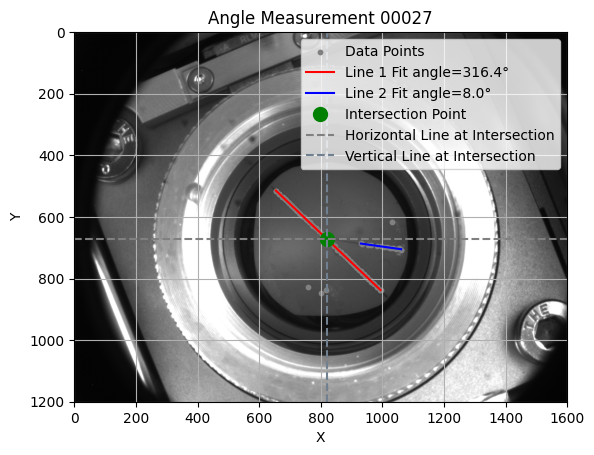

In [39]:
image_file_name = file_list[img_index%len(file_list)]
img_index += 1

aex.Analyze_Image(image_file_name, plot_level=1, verbose_level=1)